<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
from IPython.display import clear_output
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import pandas as pd
import skimage.io
from skimage.transform import resize
import random
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
data, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
train_data, val_data, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, shuffle=False)


In [ ]:
train_data = torch.FloatTensor(train_data)
val_data = torch.FloatTensor(val_data)

In [ ]:
train_data.shape[0]

11828

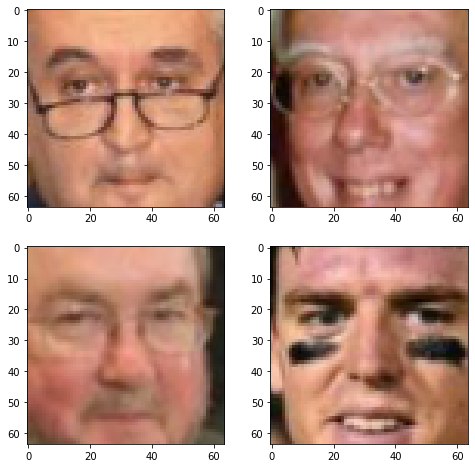

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(4):
  plt.subplot(2, 2, i+1)
  plt.imshow(train_data[random.randint(0,train_data.shape[0])])

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 64 # выберите размер латентного вектора

In [ ]:
train_data.shape

torch.Size([11828, 64, 64, 3])

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.flatten = nn.Flatten()
 
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5),#(32, 56, 56)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=32*56*56, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features = 512, out_features=dim_code)
            )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=dim_code, out_features=512),
            nn.ReLU(),
            nn.Linear(512, 32*56*56),
            nn.ReLU(),
            nn.Unflatten(1, (32, 56, 56)),
            nn.ConvTranspose2d(32, 16, 5),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 5),
            nn.ReLU()
        )

    def forward(self, x):
        #<реализуйте forward проход автоэнкодера
        #в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
        #и полученная реконструкция изображения (reconstruction)>
        latent_code = self.encoder(x.view(-1, 3, 64, 64))
        reconstruction = self.decoder(latent_code).view(-1, 64, 64, 3)

        return reconstruction, latent_code

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = F.mse_loss #log_likelihood #<loss>

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters()) #<Ваш любимый оптимизатор>

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32)

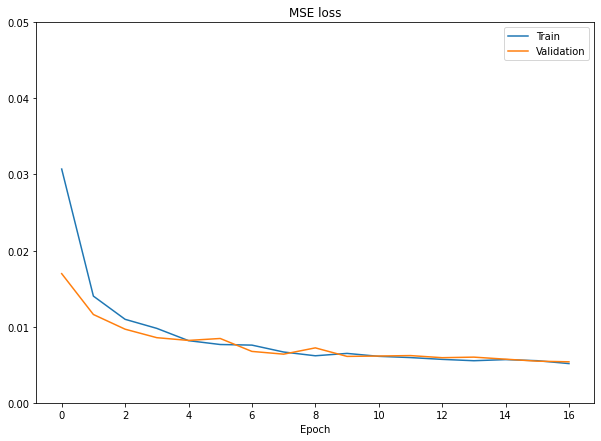

100%|██████████| 17/17 [12:37<00:00, 44.56s/it]


In [ ]:
#<тут Ваш код тренировки автоэнкодера>
n_epochs = 17
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        reconstructed, latent_code = autoencoder(X_batch.to(device))
        loss = criterion(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          reconstructed, latent_code = autoencoder(X_batch.to(device))
          loss = criterion(reconstructed, X_batch.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))
    clear_output(wait=True)
    plt.figure(figsize=(10, 7))
    plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
    plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

    plt.ylim(0, 0.05)
    plt.xlabel('Epoch')
    plt.title('MSE loss')
    plt.legend()
    plt.show()

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
autoencoder.eval()
with torch.no_grad():
    for batch in val_loader:
        reconstruction, latent_code = autoencoder(batch.to(device))
        reconstruction = reconstruction.view(-1, 64, 64, 3)
        result = reconstruction.cpu().detach().numpy()
        ground_truth = batch.numpy()
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 576x1440 with 0 Axes>

<Figure size 576x1440 with 0 Axes>

<Figure size 576x1440 with 0 Axes>

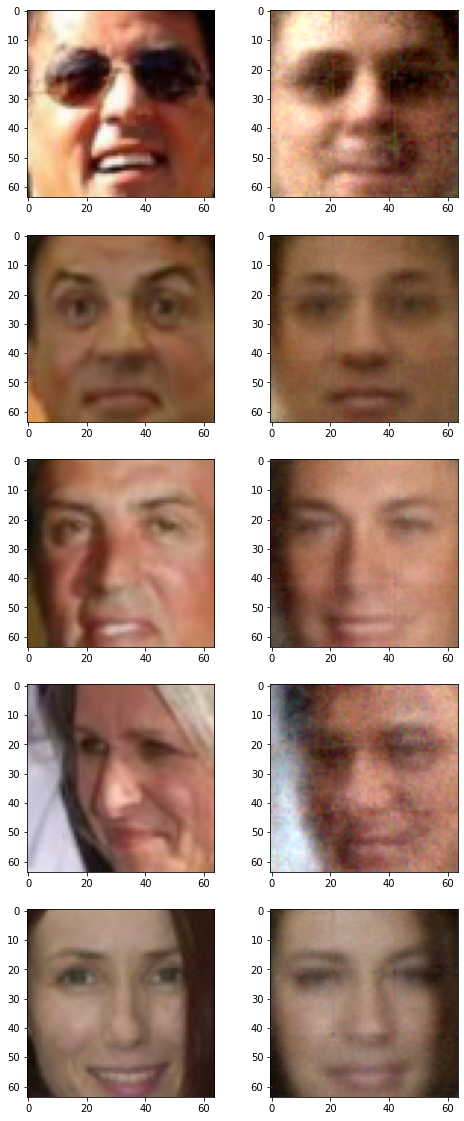

In [ ]:
#< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
for i in range(4):
  plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(gt)
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(res)

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
reconstruction, latent_code = autoencoder.forward(val_data.to(device))

In [ ]:
mean = np.mean(latent_code.detach().cpu().numpy(), axis=0)
var = np.var(latent_code.detach().cpu().numpy(), axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

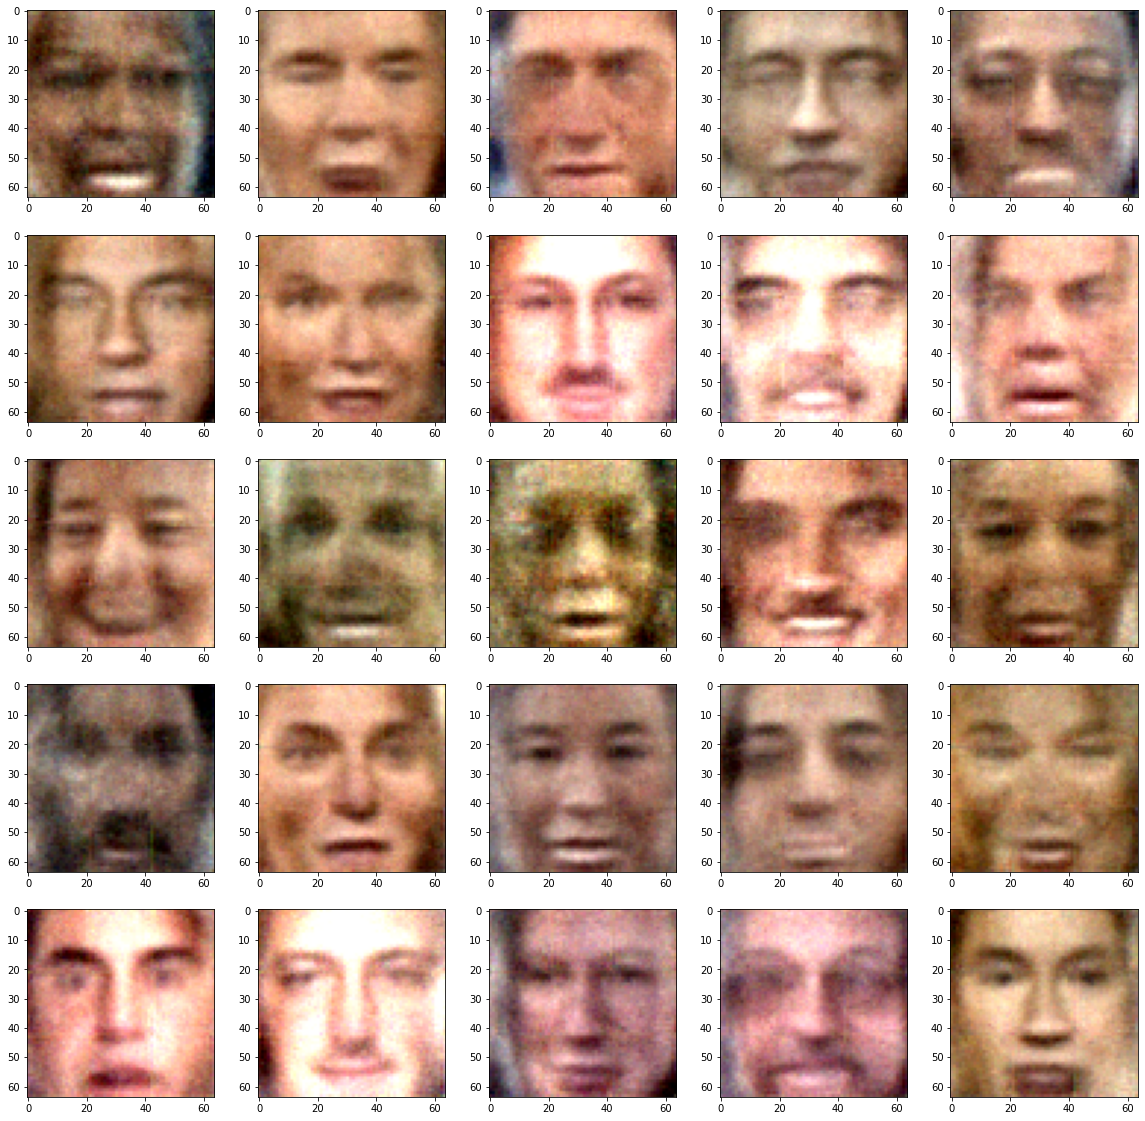

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, dim_code)*var*4.25 + mean
output = autoencoder.decoder(torch.FloatTensor(z).to(device)).view(-1, 64, 64, 3)
plt.figure(figsize=(20, 20))
for i in range(output.shape[0]):
  plt.subplot(5, 5, i + 1)
  generated = output[i].cpu().detach().numpy()
  plt.imshow(generated)

plt.show()

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
smile = random.sample([i for i, el in enumerate(train_attrs['Smiling'].to_numpy() > 2) if el == True], 20)
nsmile = random.sample([i for i, el in enumerate(train_attrs['Smiling'].to_numpy() < -2) if el == True], 20)
print(len(smile), len(nsmile))

20 20


In [ ]:
train_data[smile].shape

torch.Size([20, 64, 64, 3])

In [ ]:
#<ваш код здесь>
latent_smile = autoencoder.encoder(train_data[smile].view(-1, 3, 64, 64).to(device))
latent_nsmile = autoencoder.encoder(train_data[nsmile].view(-1, 3, 64, 64).to(device))

In [ ]:
latent_vector_smile = latent_smile - latent_nsmile
latent_vector_mean_smile = torch.mean(latent_vector_smile, dim = 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

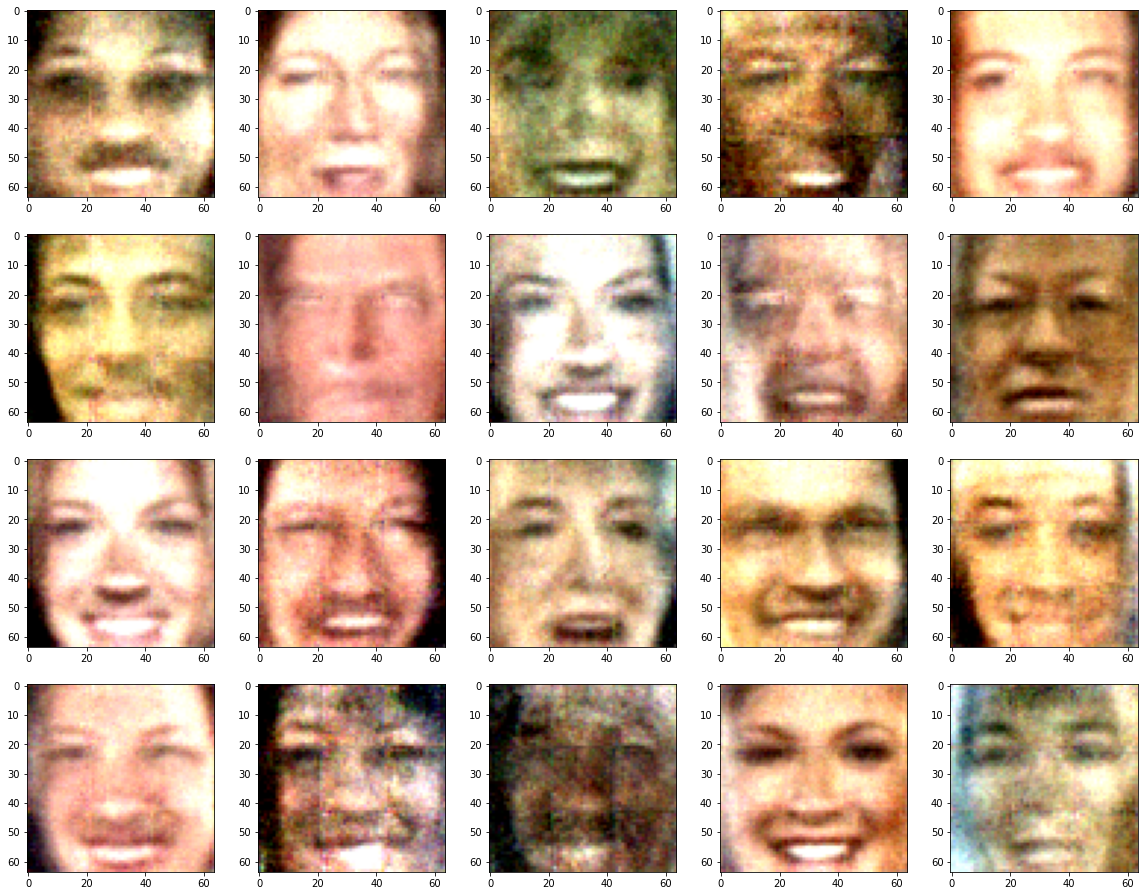

In [ ]:
z = np.random.randn(20, dim_code)*var*4.5 + mean
output = autoencoder.decoder(torch.FloatTensor(z).to(device) + latent_vector_smile).view(-1, 64, 64, 3)
plt.figure(figsize=(20, 20))
for i in range(output.shape[0]):
  plt.subplot(5, 5, i + 1)
  generated = output[i].cpu().detach().numpy()
  plt.imshow(generated)

plt.show()

In [ ]:
nonsmile = [i for i, el in enumerate(train_attrs['Smiling'].to_numpy() < -2.3) if el == True][-9:]

In [ ]:
latent_vector_smile.shape

torch.Size([20, 64])

In [ ]:
autoencoder.eval()

latent_code = autoencoder.encoder(train_data[nonsmile].view(-1,3,64,64).to(device))
print(latent_code.shape)
reconstruction = autoencoder.decoder(latent_code).view(-1, 64, 64, 3)
reconstruction_smiling = autoencoder.decoder(latent_code + latent_vector_mean_smile).view(-1, 64, 64, 3)
result = reconstruction.cpu().detach().numpy()
result_smiling = reconstruction_smiling.cpu().detach().numpy()
ground_truth = train_data[nonsmile].numpy()


torch.Size([9, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 576x1440 with 0 Axes>

<Figure size 576x1440 with 0 Axes>

<Figure size 576x1440 with 0 Axes>

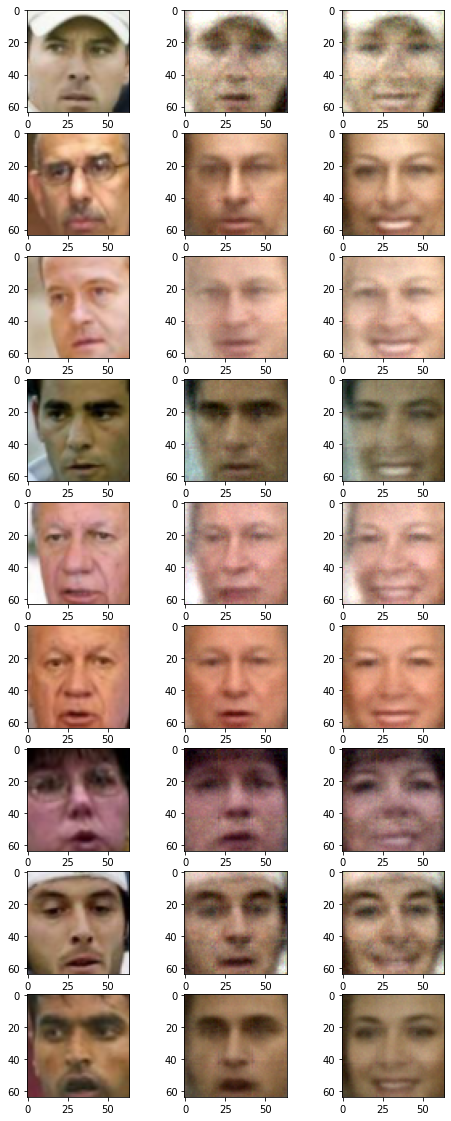

In [ ]:
 for i in range(4):
  plt.figure(figsize=(8, 20))
for i, (gt, res, res_smile) in enumerate(zip(ground_truth, result, result_smiling)):
  plt.subplot(9, 3, 3*i+1)
  plt.imshow(gt)
  plt.subplot(9, 3, 3*i+2)
  plt.imshow(res)
  plt.subplot(9, 3, 3*i+3)
  plt.imshow(res_smile)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
features = 16

class VAE(nn.Module):
    def __init__(self):
        #<определите архитектуры encoder и decoder
        #помните, у encoder должны быть два "хвоста", 
        #т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 4, 2, 2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 4, 2, 2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2048, 128),
            nn.ReLU(),
            nn.Linear(128,2*features),
        )

        self.decoder = nn.Sequential(
            nn.Linear(features, 128),
            nn.ReLU(),
            nn.Linear(128, 2048),
            nn.ReLU(),
            nn.Unflatten(1, (32, 8, 8)),
            nn.ConvTranspose2d(32, 16, 4, 2, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 6, 2, 2),
            nn.Sigmoid()
        )

    def encode(self, x):
        #<реализуйте forward проход энкодера
        #в качестве ваозвращаемых переменных -- mu и logsigma>
        x = self.encoder(x.float()).view(-1, 2, features)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            #<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        #<реализуйте forward проход декодера
        #в качестве возвращаемой переменной -- reconstruction>
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        #<используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma = self.encode(x)
        reconstruction = self.decode(self.gaussian_sampler(mu, logsigma))
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu**2 - torch.exp(logsigma)) #<напишите код для KL-дивергенции, пользуясь формулой выше>
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction) #<соедините тут две компоненты лосса. Mind the sign!>

И обучим модель:

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())#<Ваш любимый оптимизатор>

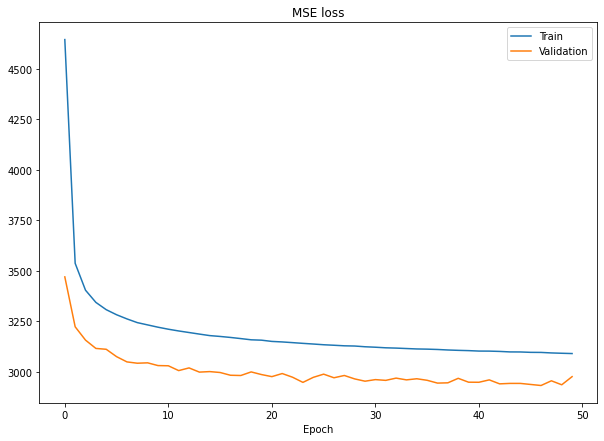

100%|██████████| 50/50 [22:03<00:00, 26.47s/it]


In [ ]:
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        mu, logsigma, reconstruction = autoencoder.forward(batch[0].to(device))
        #reconstruction = reconstruction.view(-1, 28, 28, 1)
        loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in test_loader:
          mu, logsigma, reconstruction = autoencoder.forward(batch[0].to(device))
          #reconstruction = reconstruction.view(-1, 28, 28, 1)
          loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())
    
    #<обучите модель на датасете MNIST>

    val_losses.append(np.mean(val_losses_per_epoch))
    clear_output(wait=True)
    plt.figure(figsize=(10, 7))
    plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
    plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

    plt.xlabel('Epoch')
    plt.title('VAE loss')
    plt.legend()
    plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

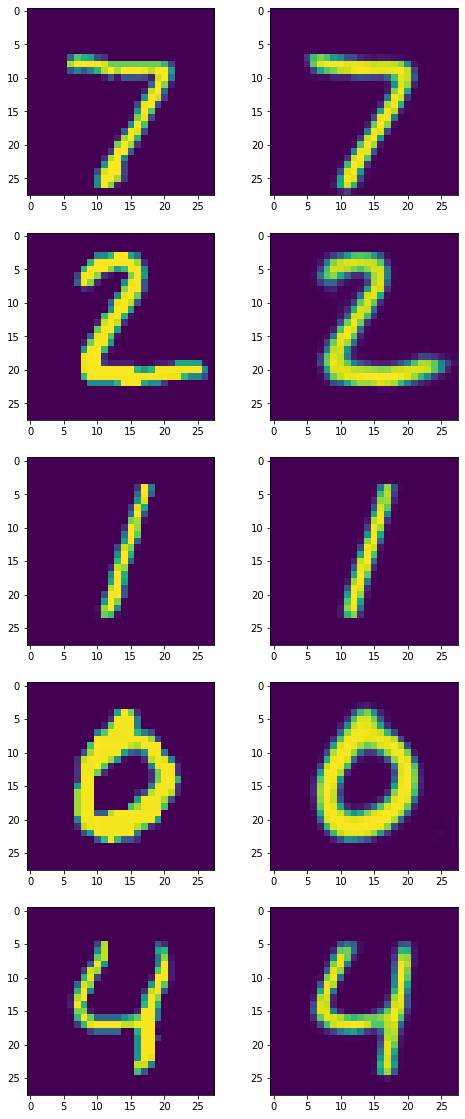

In [ ]:
#< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
autoencoder.eval()
with torch.no_grad():
    for batch in test_loader:
        mu, logsigma, reconstruction = autoencoder.forward(batch[0].to(device))
        result = reconstruction.cpu().detach().numpy()
        ground_truth = batch[0].numpy()
        break

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(gt[0,:,:])
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(res[0,:,:])

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

torch.Size([10, 1, 28, 28])


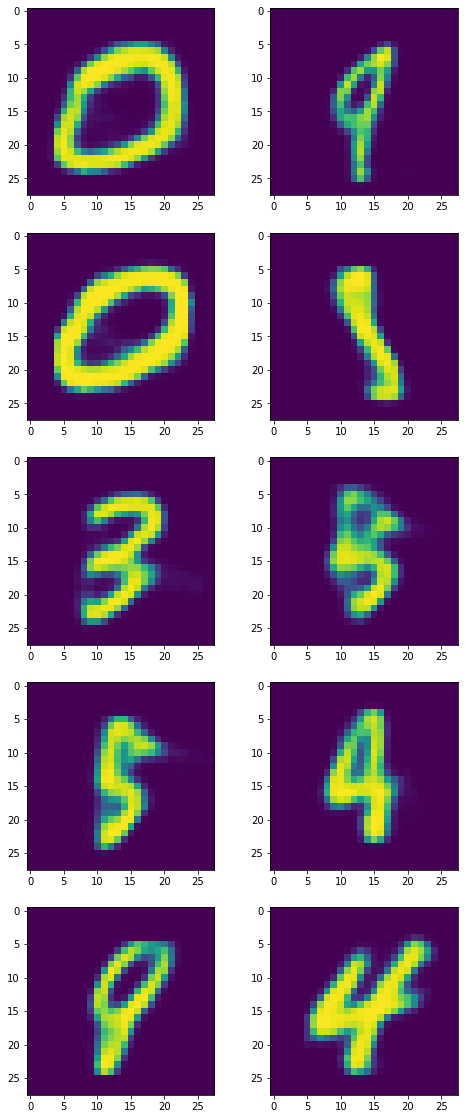

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 16) for i in range(10)])
output = autoencoder.decode(torch.FloatTensor(z).to(device)) #<скормите z декодеру>
print(output.shape)
#<выведите тут полученные картинки>
plt.figure(figsize=(8, 20))
for i, image in enumerate(output.cpu().detach().numpy()):
  plt.subplot(5,2,i+1)
  plt.imshow(image[0,:,:])

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
#<ваш код получения латентных представлений, применения TSNE и визуализации>
mu, logsigma = autoencoder.encode(train_dataset.data[:,None,:,:].to(device))
latent_code = autoencoder.gaussian_sampler(mu, logsigma)

In [ ]:
latent_code = latent_code.cpu().detach().numpy()

In [ ]:
latent_code_embedded = TSNE().fit_transform(latent_code)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
latent_code_embedded.shape

(60000, 2)

In [ ]:
target = train_dataset.targets.numpy()

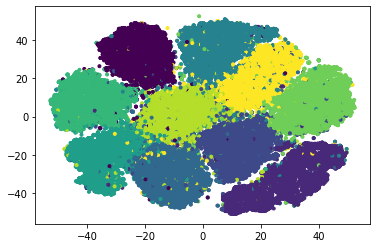

In [ ]:
plt.scatter(latent_code_embedded[:,0], latent_code_embedded[:,1], c=target, marker='.')

Что вы думаете о виде латентного представления?

Как видим признаки вполне хорошо отделяются друг от друга, хоть кое-где и есть "выбросы", но это может быть как проблемой енкодера, так и проблемой отображения в 2д пространство, так что сказать наверняка не получится

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
features = 16
class CVAE(nn.Module):
    def __init__(self):
        #<определите архитектуры encoder и decoder
        #помните, у encoder должны быть два "хвоста", 
        #т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super(CVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 4, 2, 2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 4, 2, 2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2048, 128),
            nn.ReLU(),
            nn.Linear(128,2*features),
        )

        self.decoder = nn.Sequential(
            nn.Linear(10 + features, 128),
            nn.ReLU(),
            nn.Linear(128, 2048),
            nn.ReLU(),
            nn.Unflatten(1, (32, 8, 8)),
            nn.ConvTranspose2d(32, 16, 4, 2, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 6, 2, 2),
            nn.Sigmoid()
        )

    def encode(self, x, class_num):
        #<реализуйте forward проход энкодера
        #в качестве ваозвращаемых переменных -- mu, logsigma и класс картинки>
        x = self.encoder(x.float()).view(-1, 2, features)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        return mu, logsigma, class_num
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            #<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, class_num):
        #<реализуйте forward проход декодера
        #в качестве возвращаемой переменной -- reconstruction>
        z = torch.cat((z, class_num), 1)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x, class_num):#x[0] - dataset, x[1] - targets
        #<используя encode и decode, реализуйте forward проход автоэнкодера
        #в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma, class_num = self.encode(x, class_num)
        reconstruction = self.decode(self.gaussian_sampler(mu, logsigma), class_num)
        return mu, logsigma, reconstruction

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae

autoencoder = CVAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())#<Ваш любимый оптимизатор>

train = np.array([0,1, 2, 3 ,4, 5, 6, 7, 8, 9]).reshape(-1,1)
enc = OneHotEncoder(sparse=False)
enc.fit(train)

OneHotEncoder(sparse=False)

In [ ]:
for batch in train_loader:
  x = batch[0].to(device)
  num_class = torch.IntTensor(enc.transform(np.array(batch[1]).reshape(-1,1))).to(device)
  print(x.shape, num_class.shape)
  autoencoder.forward(x,num_class)
  break

torch.Size([32, 1, 28, 28]) torch.Size([32, 10])


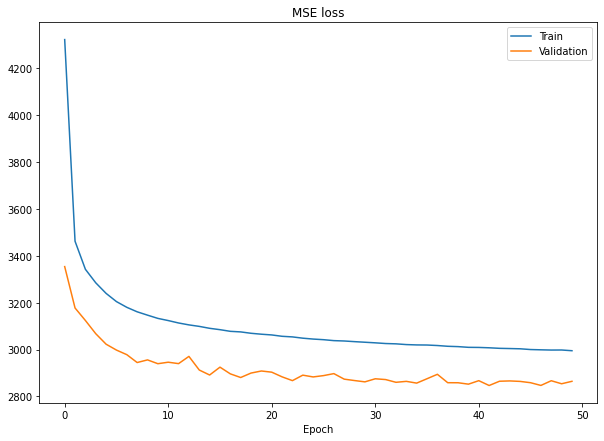

100%|██████████| 50/50 [21:32<00:00, 25.85s/it]


In [ ]:
#<тут нужно научиться сэмплировать из декодера цифры определенного класса>
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        x = batch[0].to(device)
        num_class = torch.IntTensor(enc.transform(np.array(batch[1]).reshape(-1,1))).to(device)
        optimizer.zero_grad()
        mu, logsigma, reconstruction = autoencoder.forward(x, num_class)
        loss = criterion(x.float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in test_loader:
          x = batch[0].to(device)
          num_class = torch.IntTensor(enc.transform(np.array(batch[1]).reshape(-1,1))).to(device)
          mu, logsigma, reconstruction = autoencoder.forward(x, num_class)
          loss = criterion(x.float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())
    
    #<обучите модель на датасете MNIST>

    val_losses.append(np.mean(val_losses_per_epoch))
    clear_output(wait=True)
    plt.figure(figsize=(10, 7))
    plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
    plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

    plt.xlabel('Epoch')
    plt.title('VAE loss')
    plt.legend()
    plt.show()

torch.Size([8, 1, 28, 28])


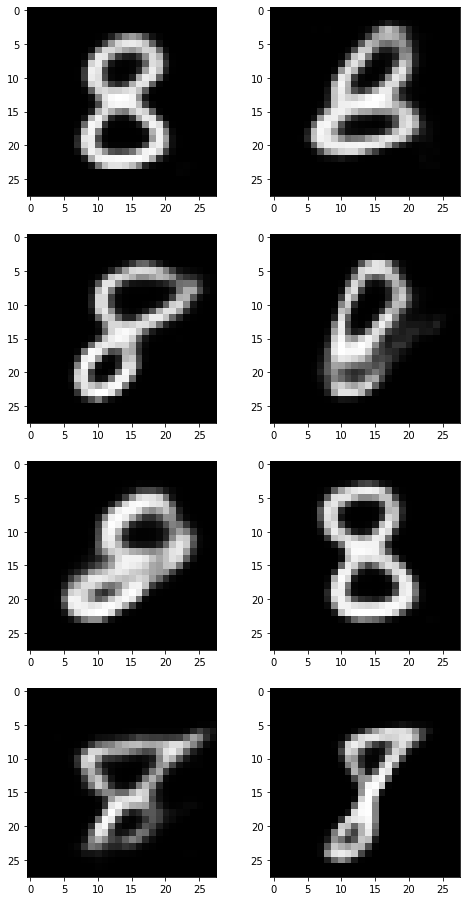

In [ ]:
z = np.array([np.random.normal(0, 1, 16) for i in range(8)])
num_class = torch.IntTensor(enc.transform(np.array([8]*8).reshape(-1,1)))
output = autoencoder.decode(torch.FloatTensor(z).to(device), num_class.to(device)) #<скормите z декодеру>
print(output.shape)

#<выведите тут полученные картинки>
plt.figure(figsize=(8, 16))
for i, image in enumerate(output.cpu().detach().numpy()):
  plt.subplot(4,2,i+1)
  plt.imshow(image[0,:,:], cmap='gray')

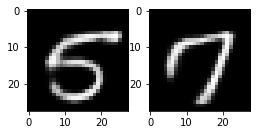

In [ ]:
z = np.array([np.random.normal(0, 1, 16) for i in range(1)])
num_class_5 = torch.IntTensor(enc.transform(np.array([5]).reshape(-1,1)))
num_class_7 = torch.IntTensor(enc.transform(np.array([7]).reshape(-1,1)))
output_5 = autoencoder.decode(torch.FloatTensor(z).to(device), num_class_5.to(device)) #<скормите z декодеру>
output_7 = autoencoder.decode(torch.FloatTensor(z).to(device), num_class_7.to(device)) #<скормите z декодеру>

#<выведите тут полученные картинки>
plt.figure(figsize=(4, 8))
plt.subplot(1,2,1)
plt.imshow(output_5.cpu().detach().numpy()[0,0,:,:], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(output_7.cpu().detach().numpy()[0,0,:,:], cmap='gray')


Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
targets = torch.IntTensor(enc.transform(np.array(train_dataset.targets).reshape(-1,1)))
print(targets.shape, train_dataset.data.shape)

torch.Size([60000, 10]) torch.Size([60000, 28, 28])


In [ ]:
#<ваш код получения латентных представлений, применения TSNE и визуализации>
targets = torch.IntTensor(enc.transform(np.array(train_dataset.targets).reshape(-1,1)))
mu, logsigma, class_num = autoencoder.encode(train_dataset.data[:,None,:,:].to(device), targets)
latent_code = autoencoder.gaussian_sampler(mu, logsigma)
latent_code = latent_code.cpu().detach().numpy()
latent_code_embedded = TSNE().fit_transform(latent_code)
target = train_dataset.targets.numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


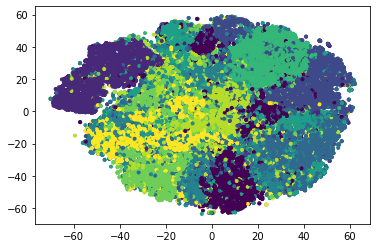

In [ ]:
plt.scatter(latent_code_embedded[:,0], latent_code_embedded[:,1], c=target, marker='.')

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Классы здесь менее различимы, но здесь не учтен one-hot вектор, который конкатенируется с латентным вектором CVAE. Также эта модель(как и предыдущая) явно недообучены, но обучались они одинаковое количество эпох. Если говорить конкретно об этом разделении, то на первый взгляд оно очень плохое т.к. классы сильно накладываются друг на друга, но ведь именно это и позволяют сгенерировать из одного латентного вектора разные цифры